# Sensor failure Detection and prediction


## Initialize Imports and mount the dataset

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt 




# Data pre/processing and modeling
import itertools
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

RANDNUM = 101
DataSet = 'sensor.csv'
# DataSet = '/content/SensorFailurePrediction/sensor-fault-detection.csv'

## Create Dataframe


In [2]:
df = pd.read_csv(DataSet, sep=',')
df.dataframename = 'sensor.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.shape

There are 220320 rows and 55 columns


(220320, 55)

Inspect our data

In [3]:
df.head(5)

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
df['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

Get some statistics about our data

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,220320.0,110159.500000,63601.049991,0.000000,55079.750000,110159.500000,165239.250000,220319.000000
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.000000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220301.0,590.673936,144.023912,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220301.0,73.396414,17.298247,0.000000,69.976260,75.576790,80.912150,99.999880
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960


In [6]:
# Collect more import info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

## Getting some understanding of our data and minor corrections 

We see from the output above, we have some null values in the set, let's check missing values for each column

In [7]:
df.isnull().sum(axis=1)
df.isnull().sum(axis=0)

Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


In [8]:
# We need to remove those who are missing 7-8% or more of their data 
df.drop(['Unnamed: 0','sensor_00','sensor_15','sensor_50','sensor_51'],axis=1, inplace=True)

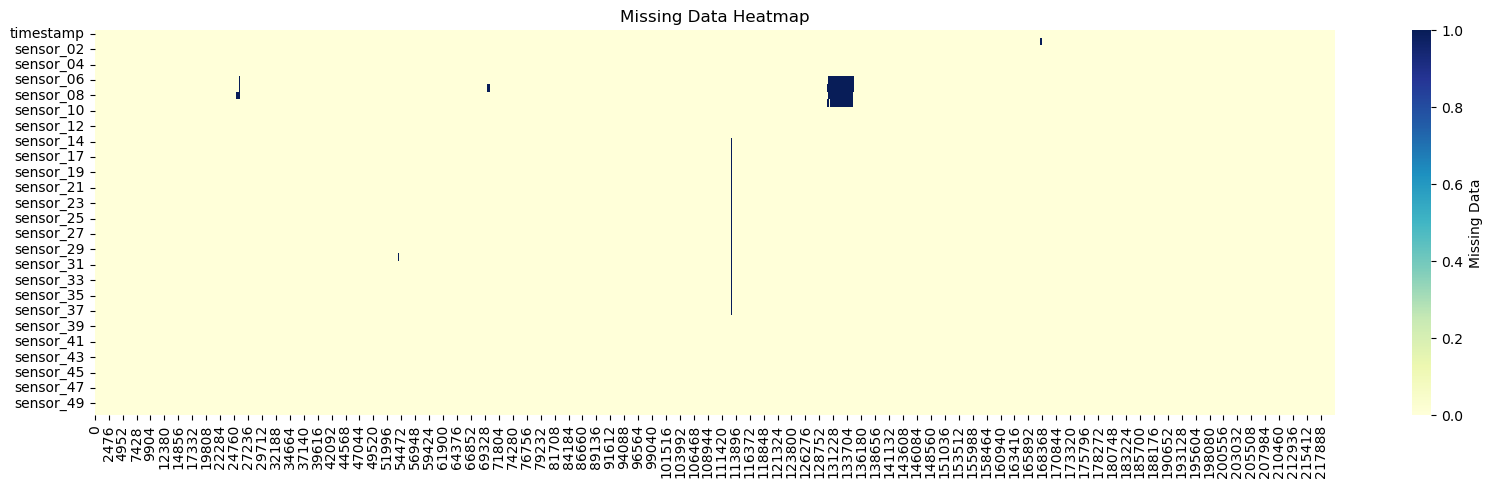

In [9]:
# Check the lost Data Locations via a heat map
plt.figure(figsize=(20,5))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.title('Missing Data Heatmap')
plt.show();

From this plot we are already able to detect some regions in which the row's are missing data, from here we can better visualize these areas

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

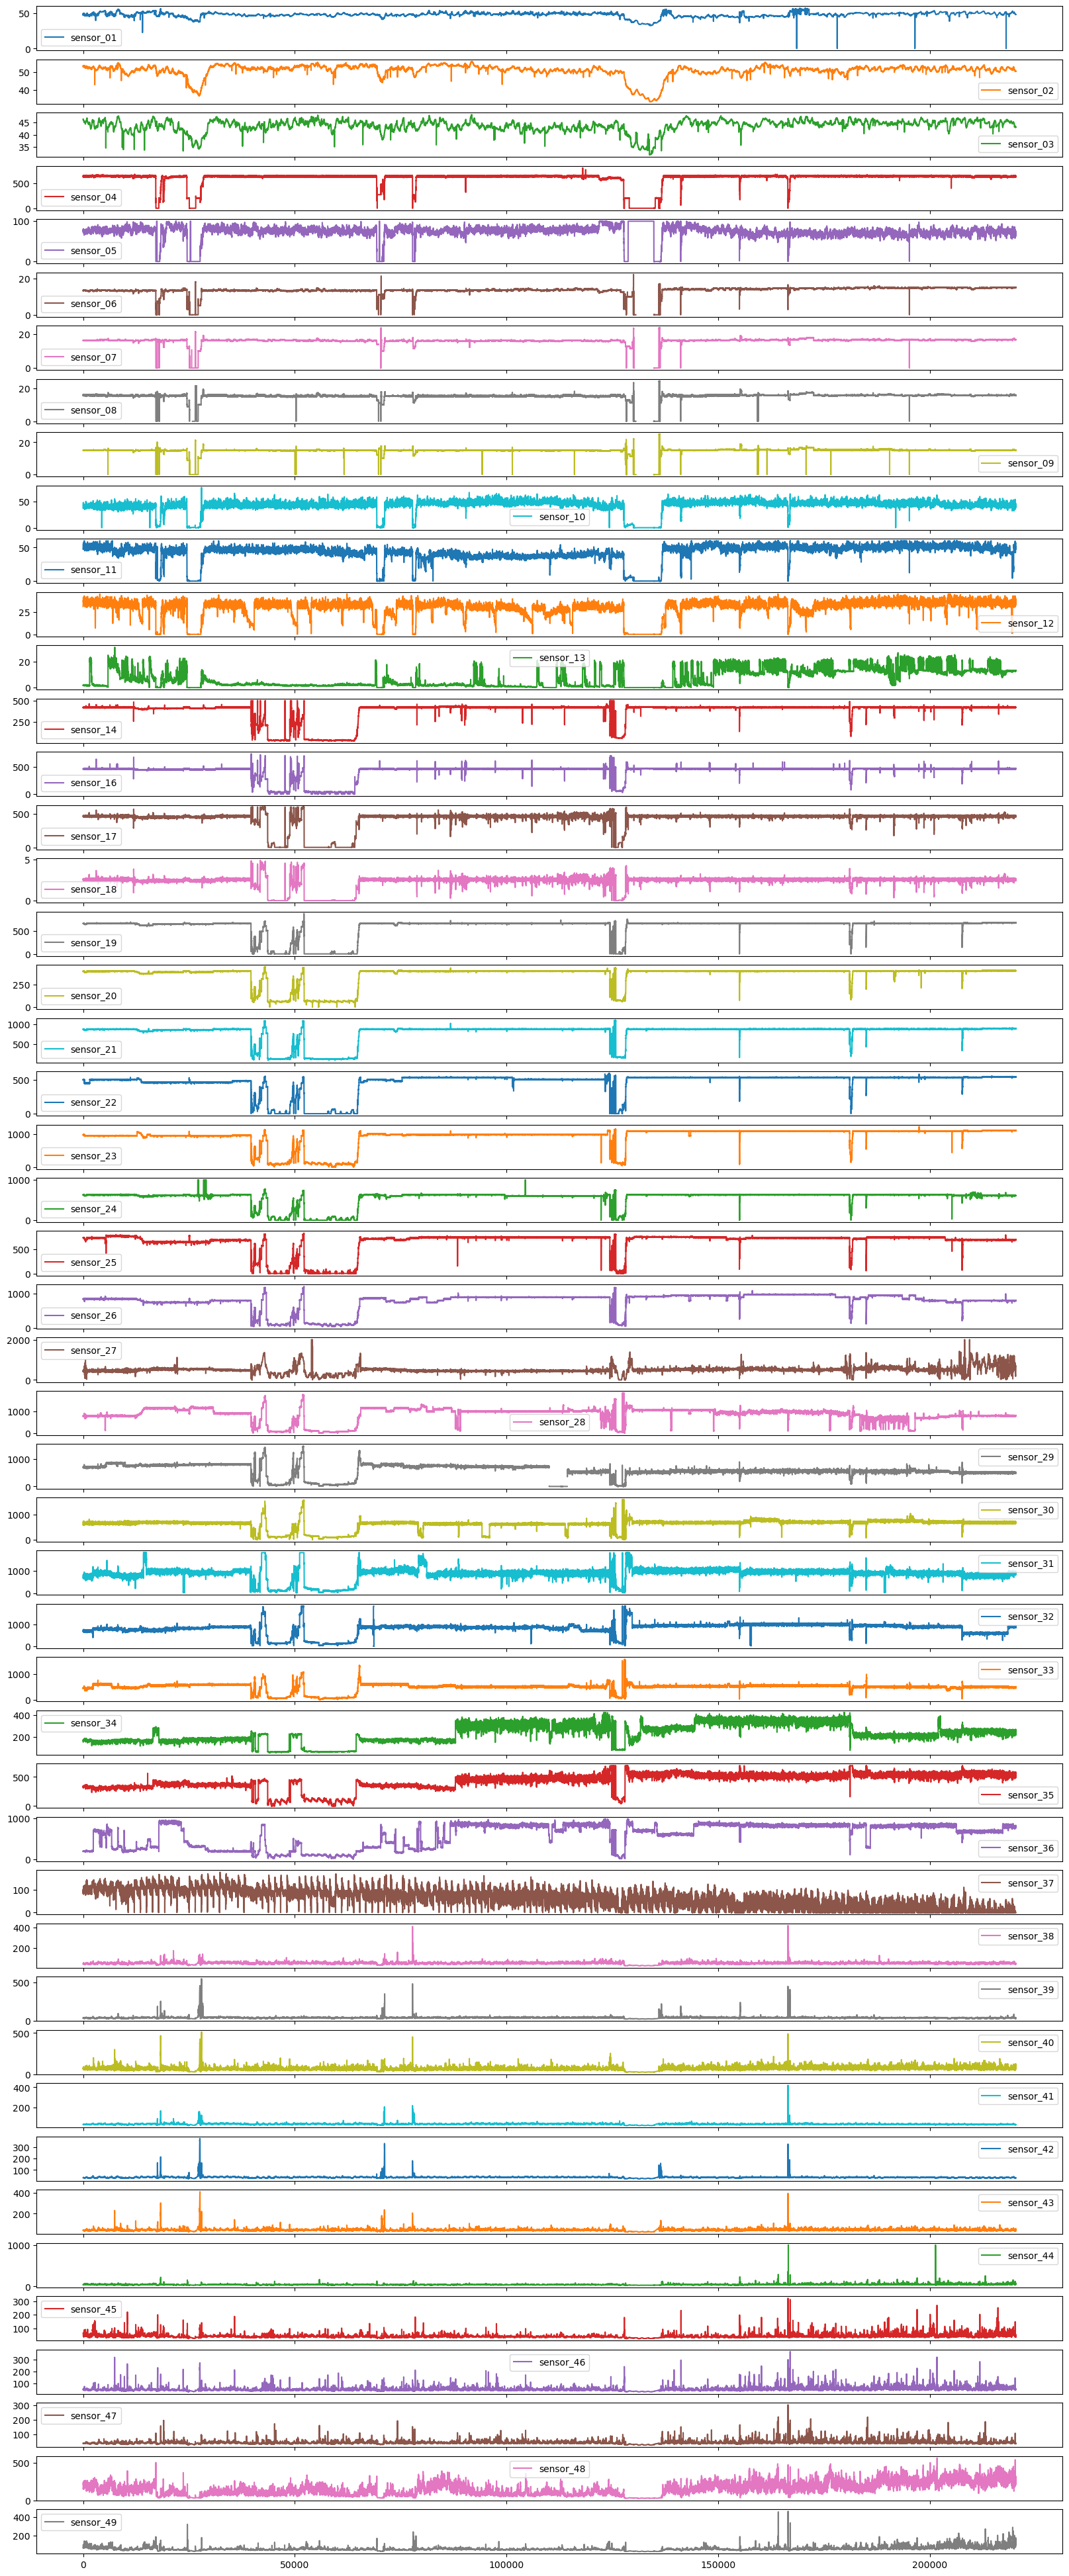

In [10]:
df.plot(subplots =True, sharex = True, figsize = (20,50))

In [11]:
# Collect num of guarenteed breaks in the system we 
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

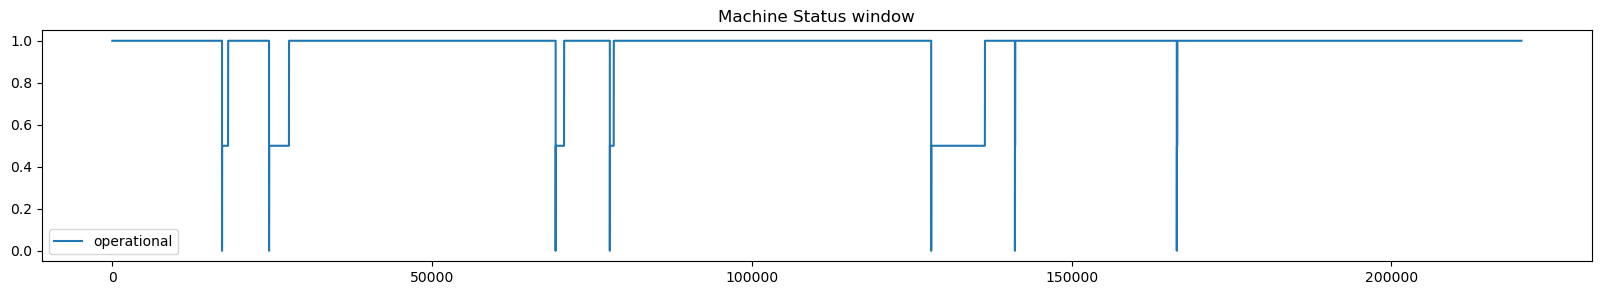

In [12]:
# create operational graph
conditions = [(df['machine_status'] == 'NORMAL'), (df['machine_status'] == 'RECOVERING'), (df['machine_status'] == 'BROKEN')]
choices = [1,0.5,0]
df['operational']  = np.select(condlist=conditions, choicelist=choices)
ax = df['operational'].plot(title='Machine Status window', legend=True, figsize=(20,3), )


In [13]:
# Seeing that we have 7 total breaks we can split this 60/40 leaving at least 2 system breaks in our test data to see if we are correctly prediciting
from sklearn.model_selection import train_test_split

last_40percent = round(len(df) - len(df)*.4)
train = df.iloc[ :last_40percent, :]
test = df.iloc[last_40percent: ,:]

In [14]:
# Verifying our Test data includes two BROKEN samples
test[test['machine_status']=='BROKEN']

,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,operational
141131,2018-07-08 00:11:00,45.138890,52.90799,45.35590,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,...,32.81250,36.19791,37.32639,35.30093,38.19444,43.40278,99.53703,44.84954,BROKEN,0.0
166440,2018-07-25 14:00:00,45.833332,52.99479,43.88021,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,...,36.45833,51.30208,52.10200,52.66204,67.12963,43.98148,230.32410,69.73380,BROKEN,0.0


### More Visualization

In [15]:
# get useful columns and rows
sensor_cols = train.iloc[:,1:]
broken_rows = train[train['machine_status']=='BROKEN']
recovery_rows = train[train['machine_status']=='RECOVERING']
normal_rows = train[train['machine_status']=='NORMAL']
machine_status_col = train['machine_status']

/tmp/ipykernel_13187/179316329.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plot = plt.figure(figsize=(22,1))


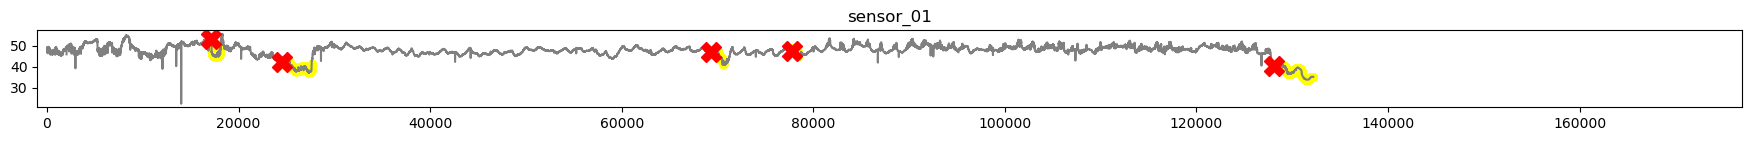

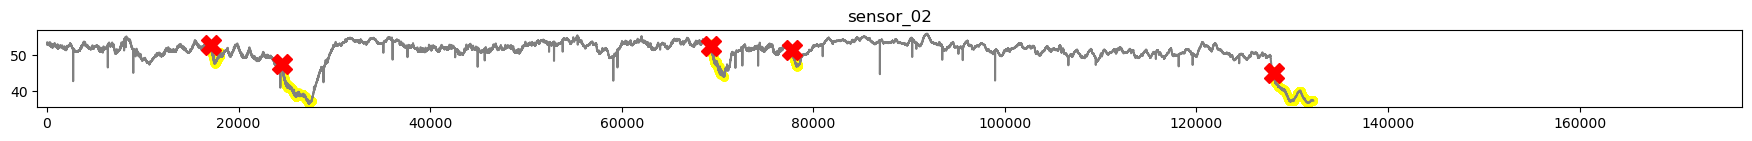

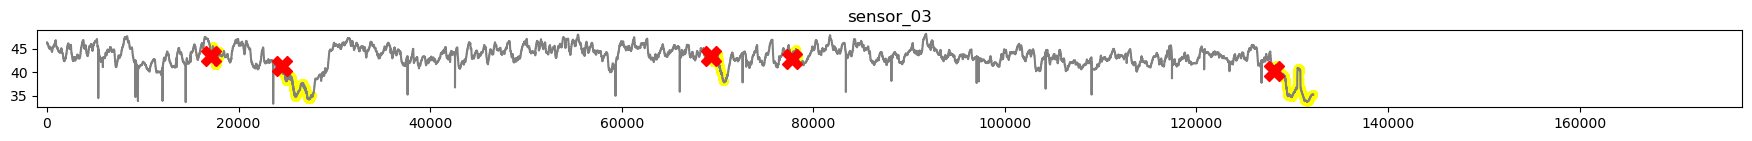

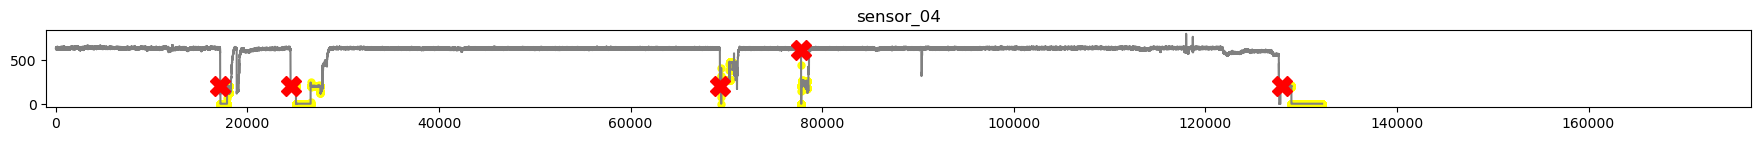

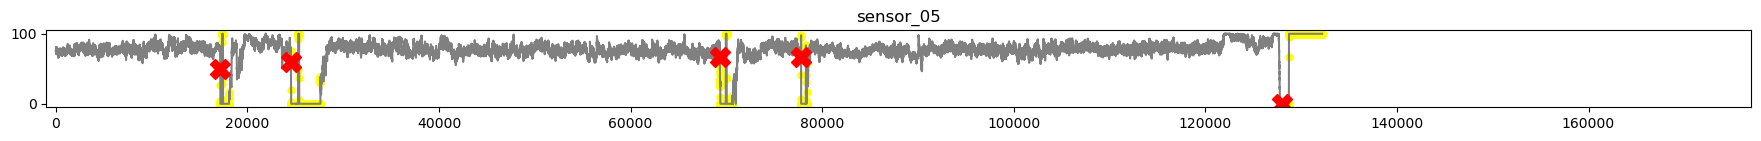

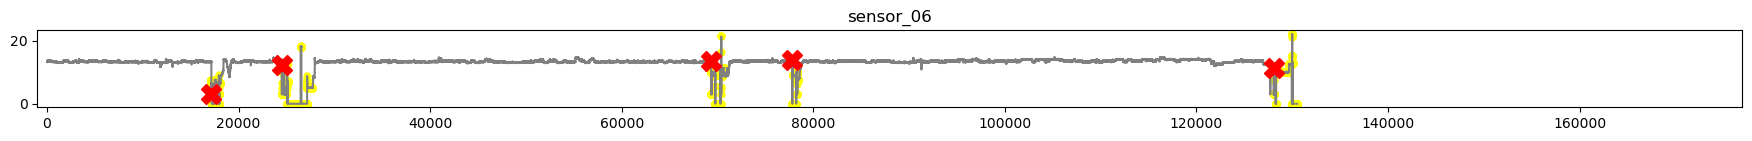

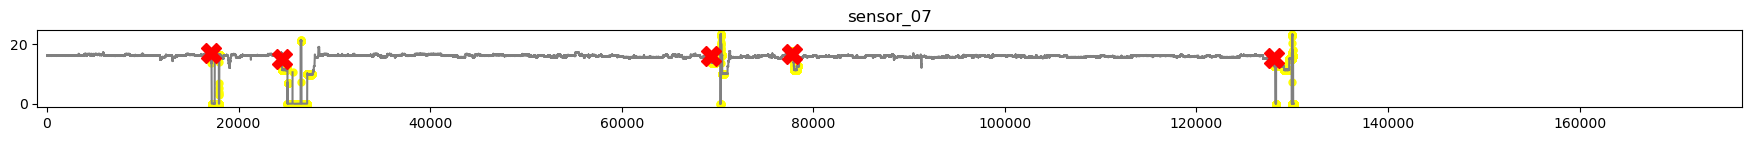

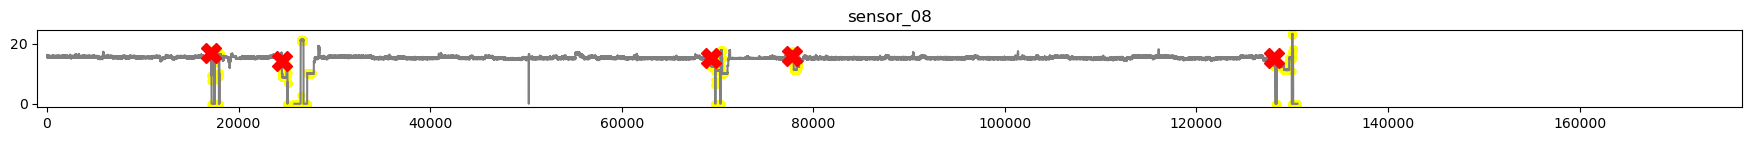

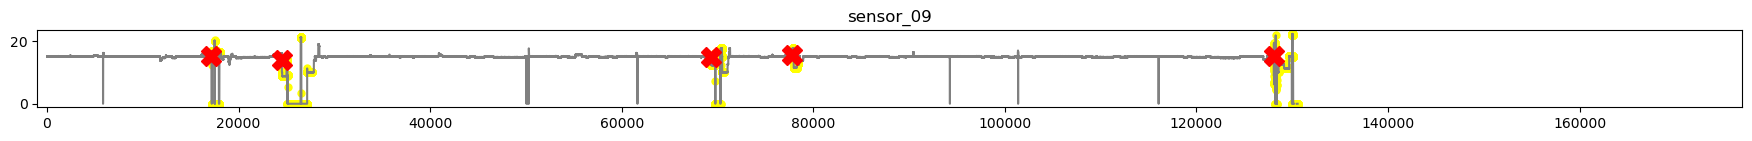

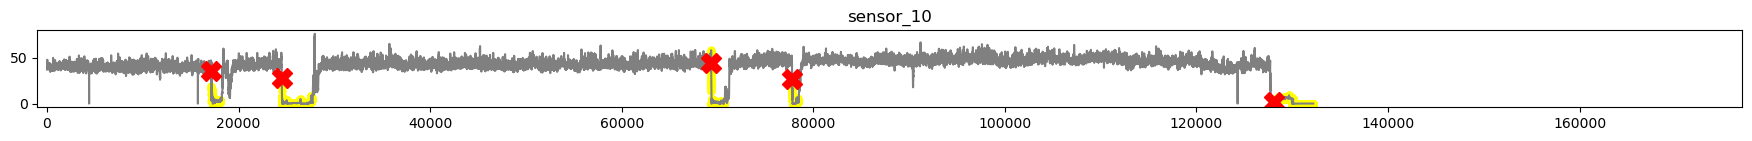

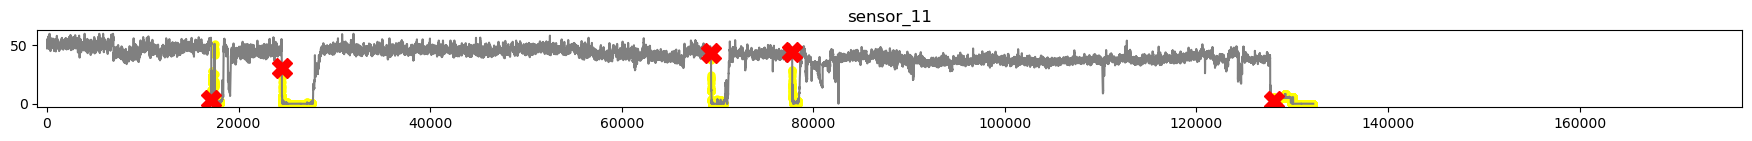

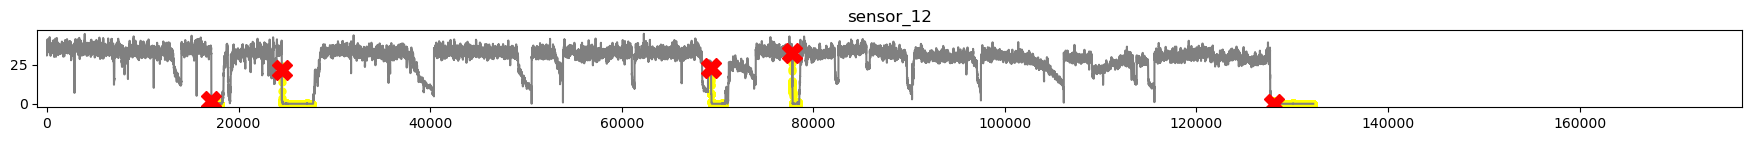

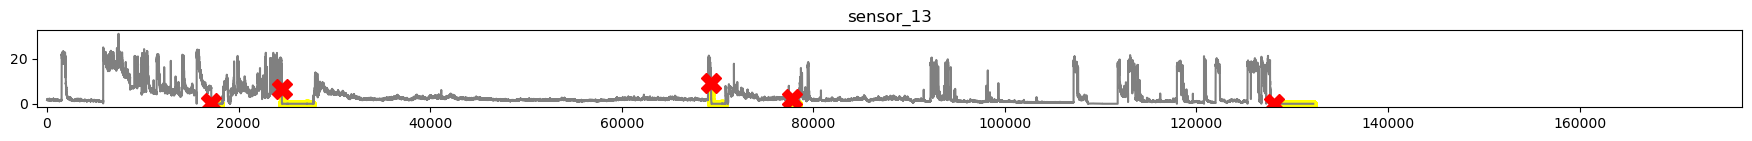

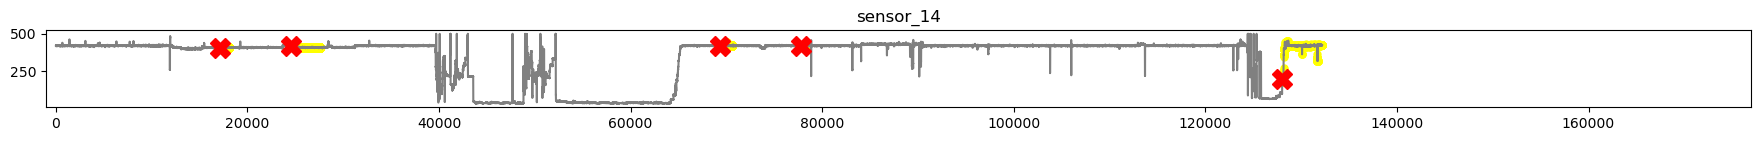

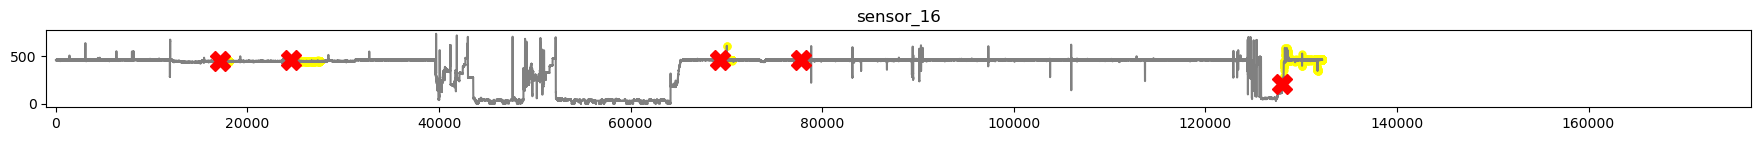

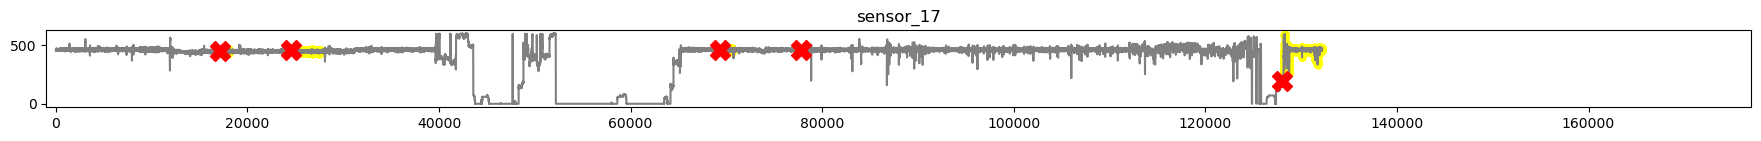

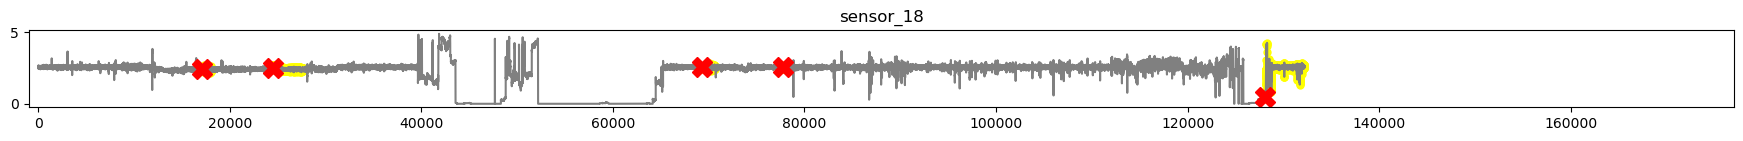

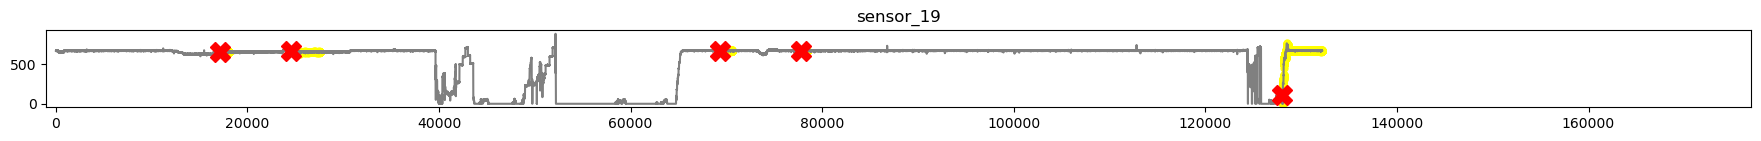

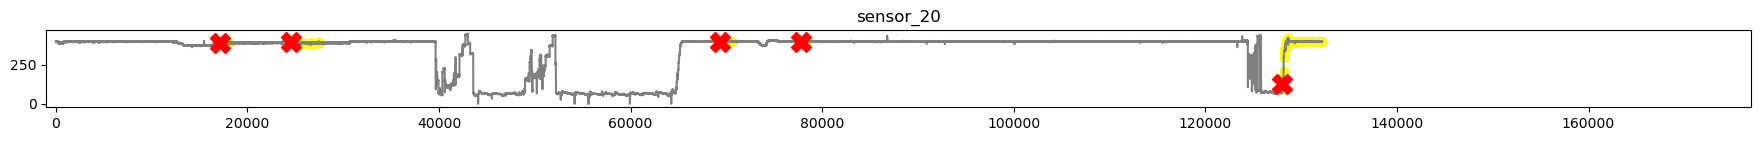

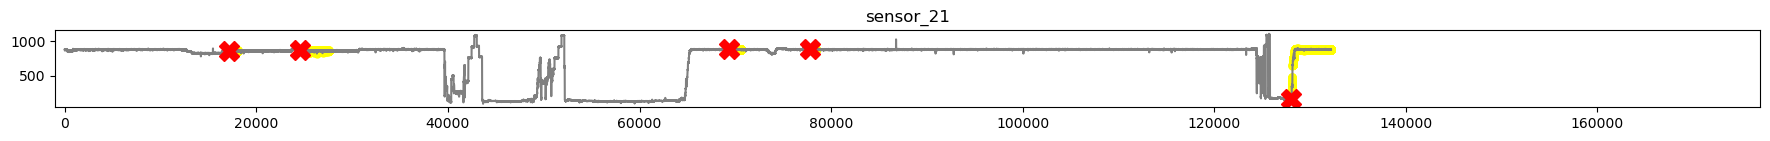

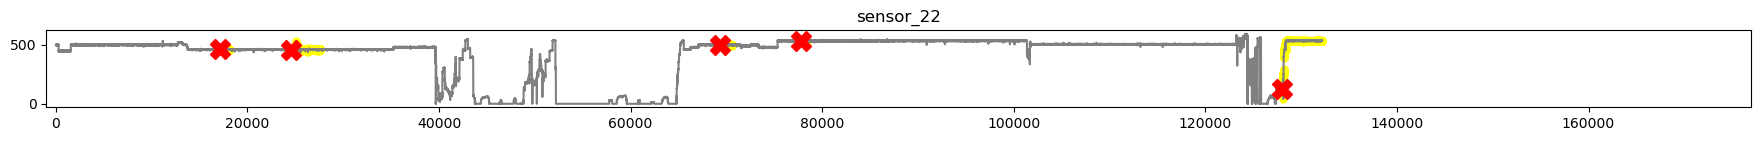

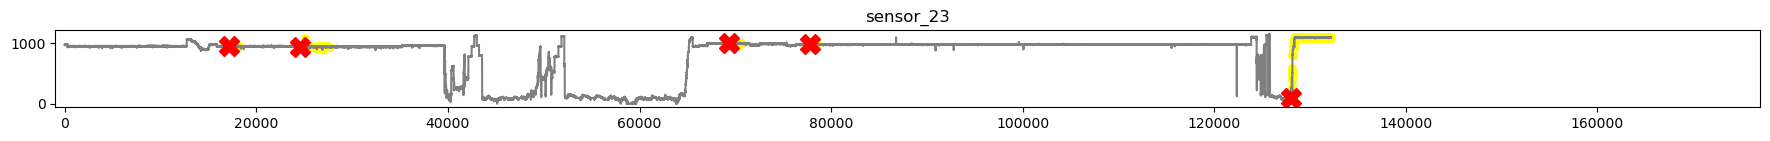

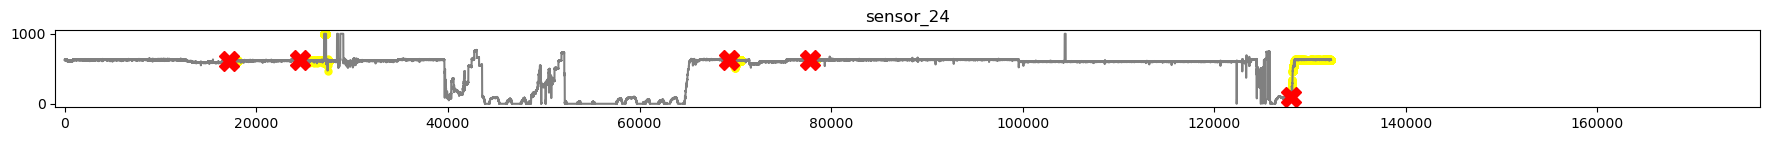

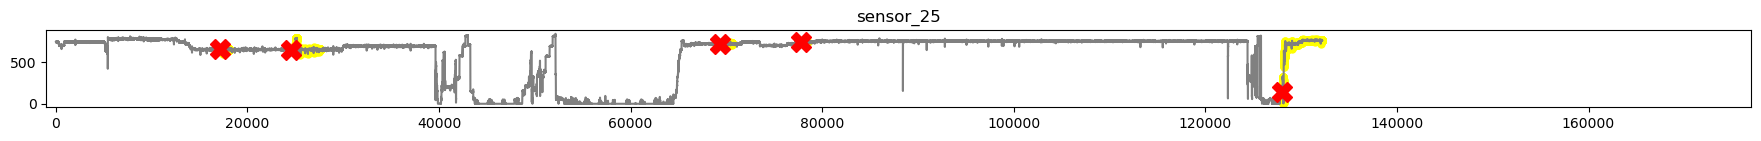

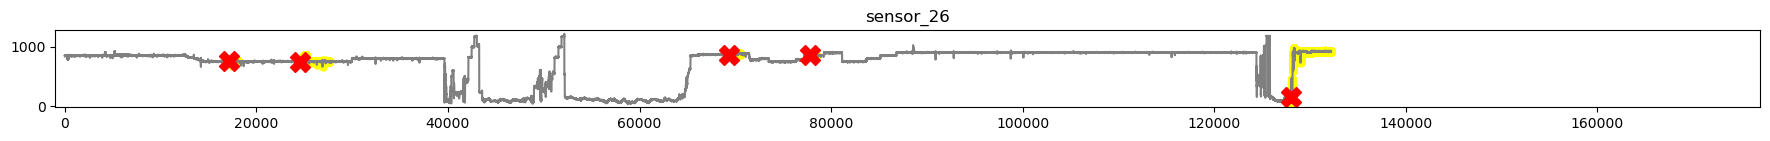

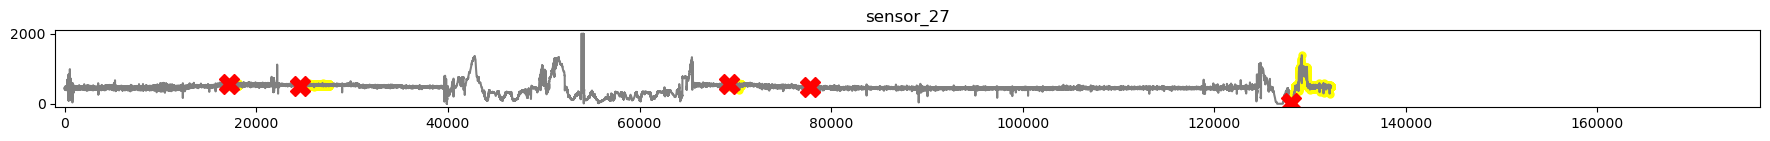

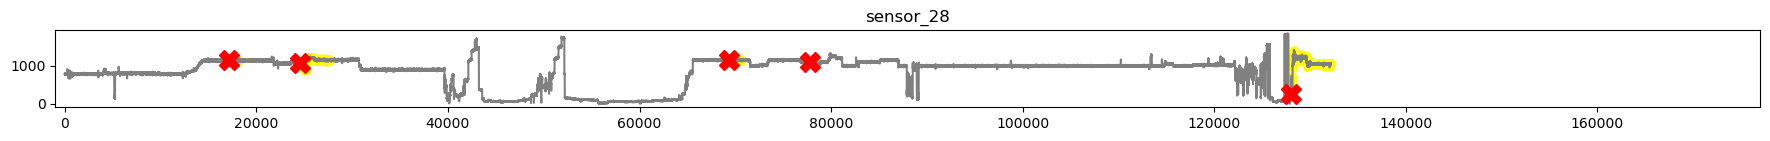

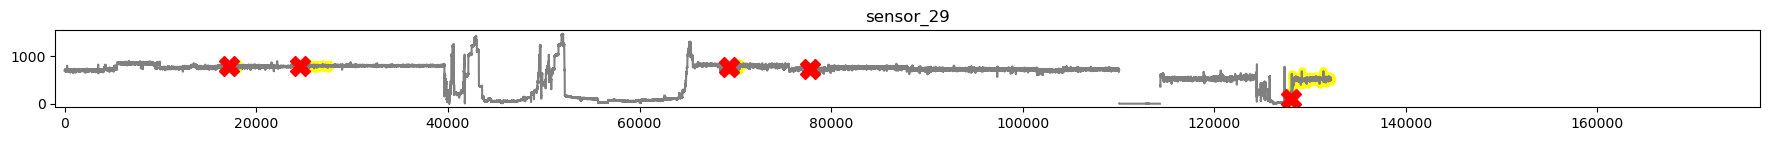

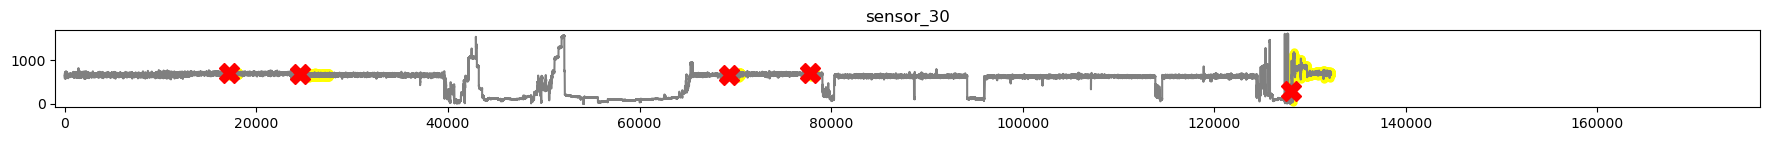

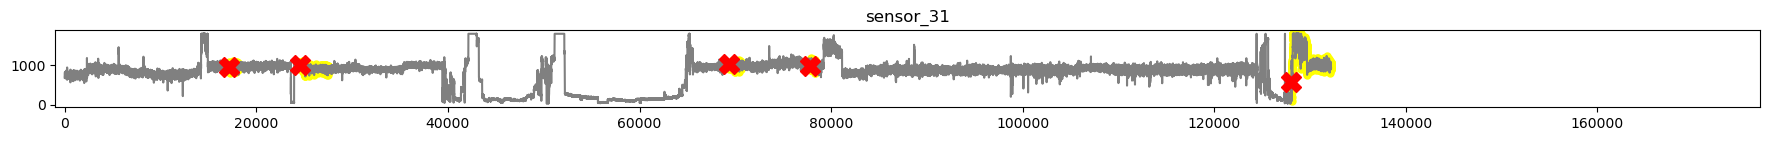

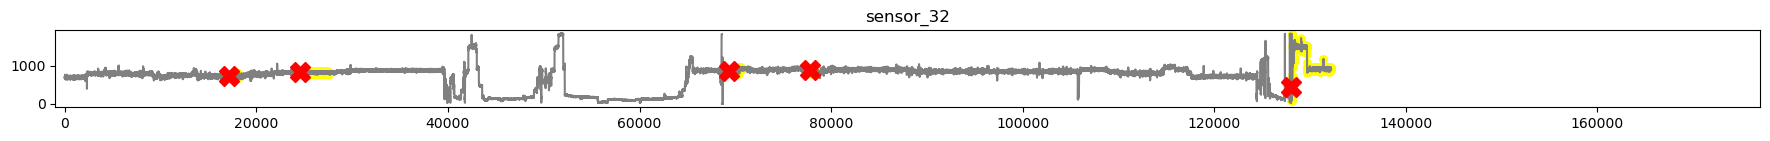

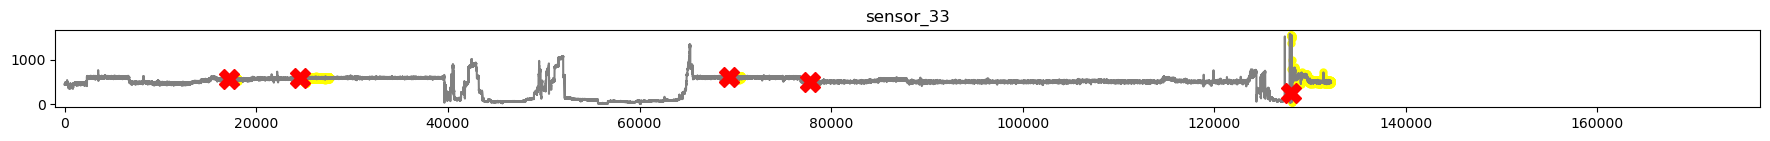

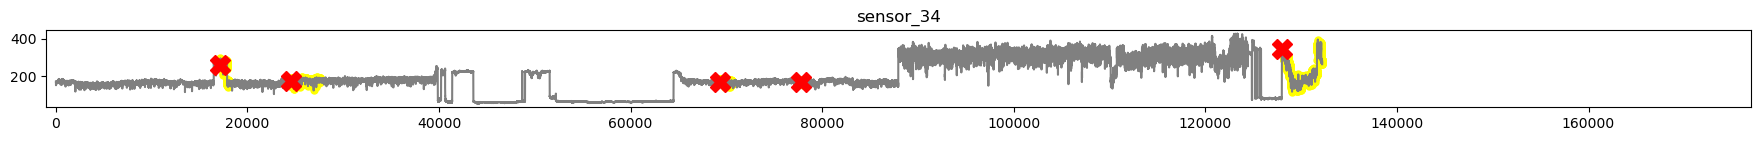

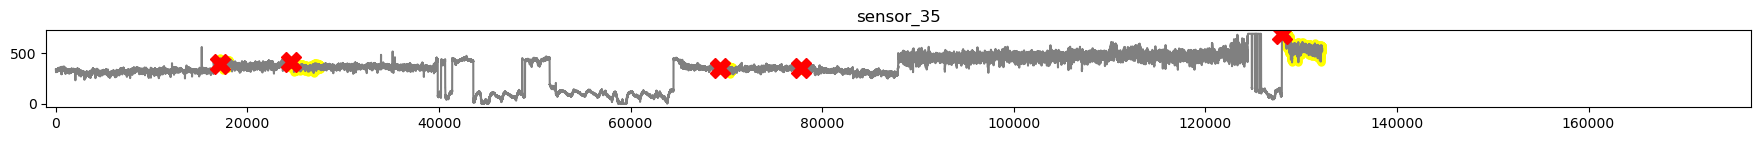

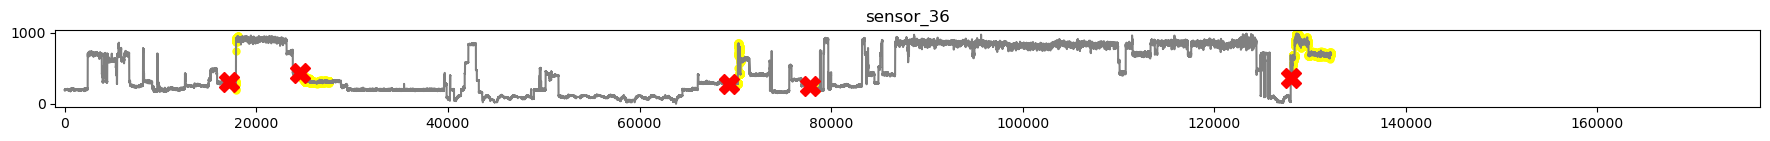

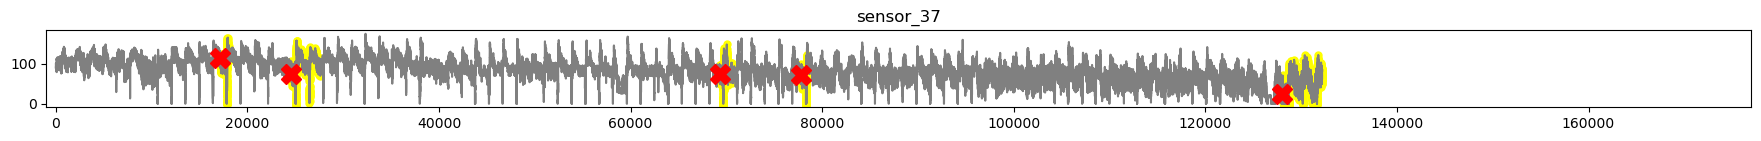

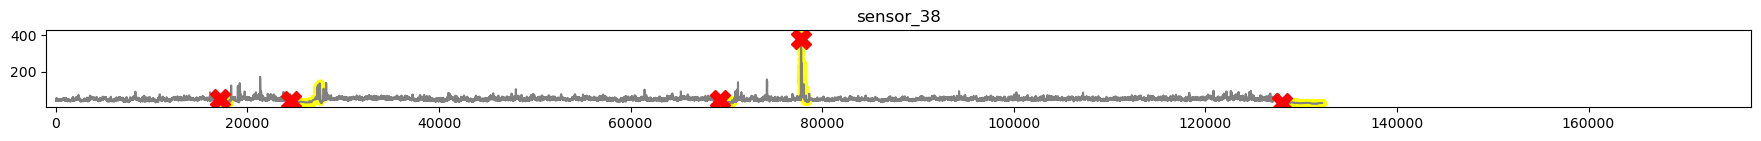

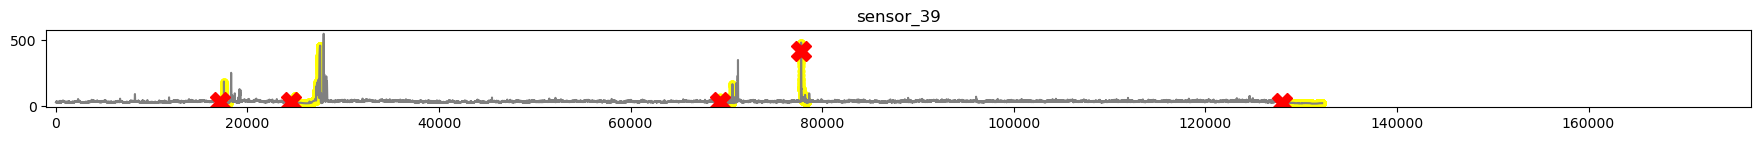

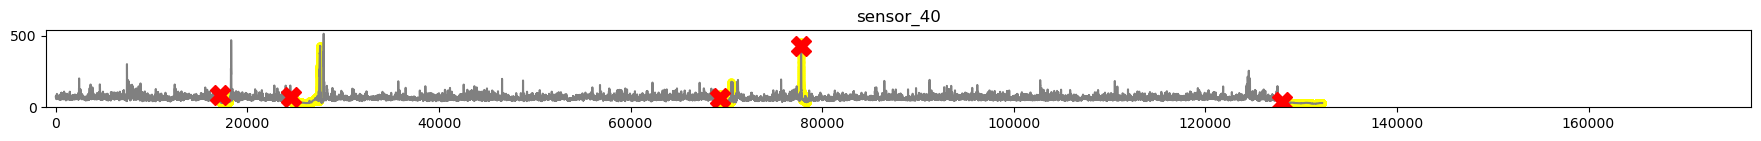

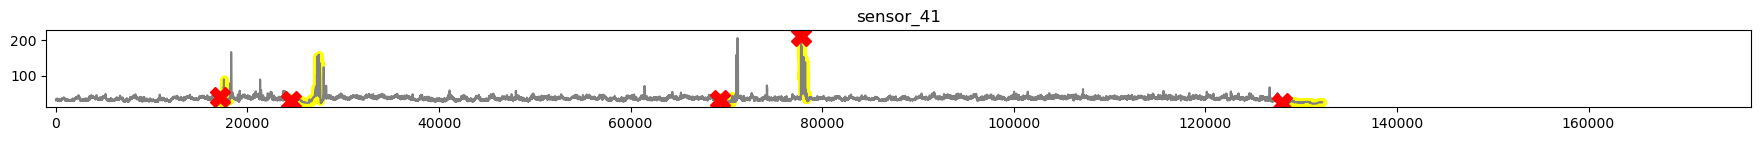

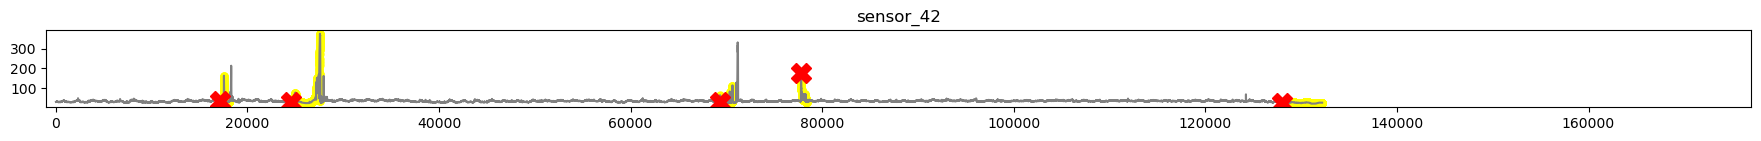

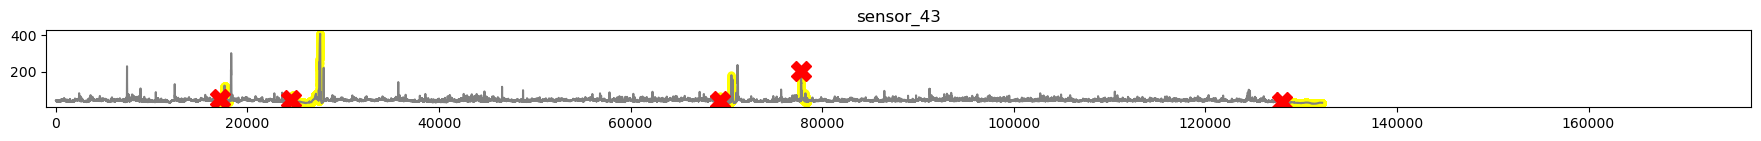

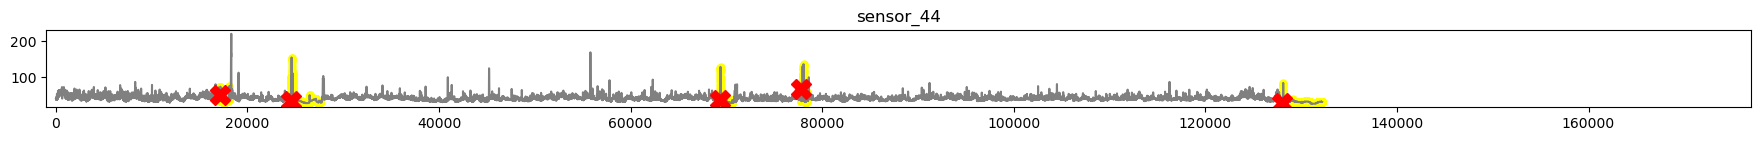

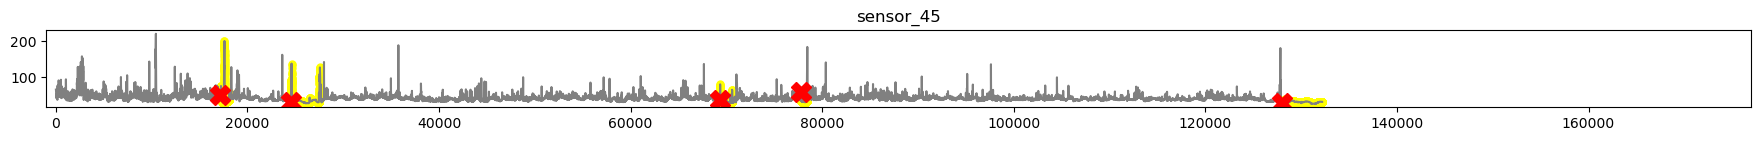

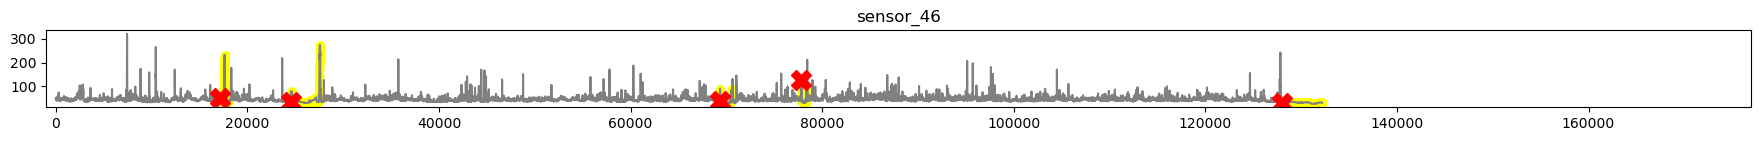

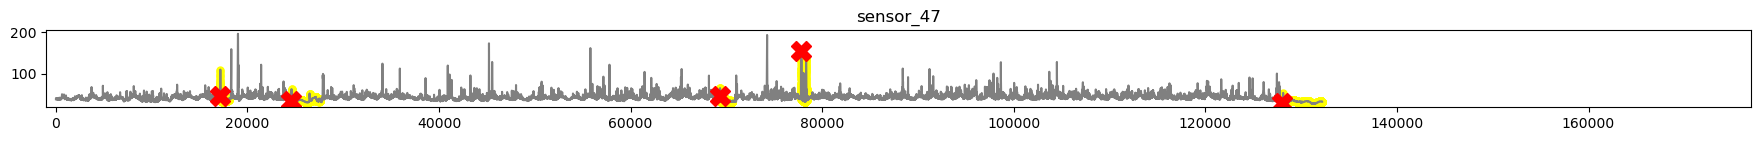

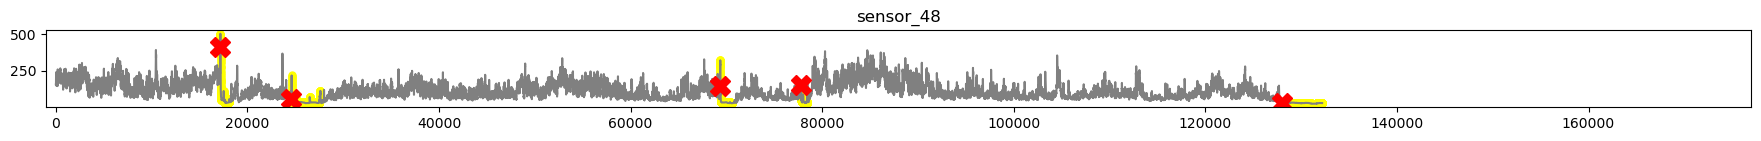

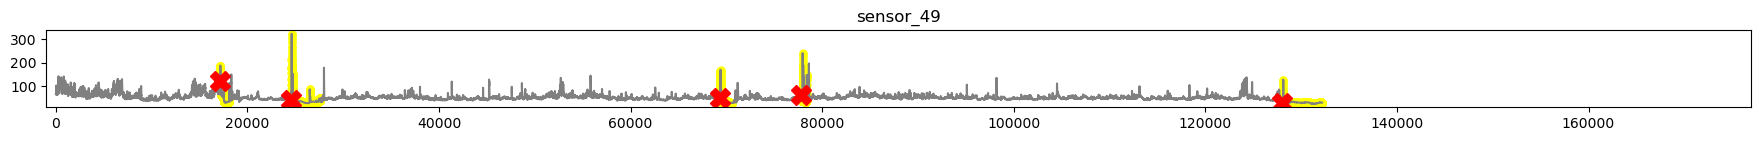

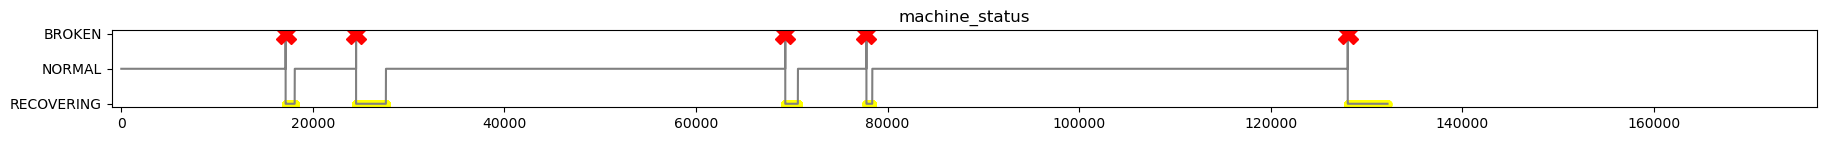

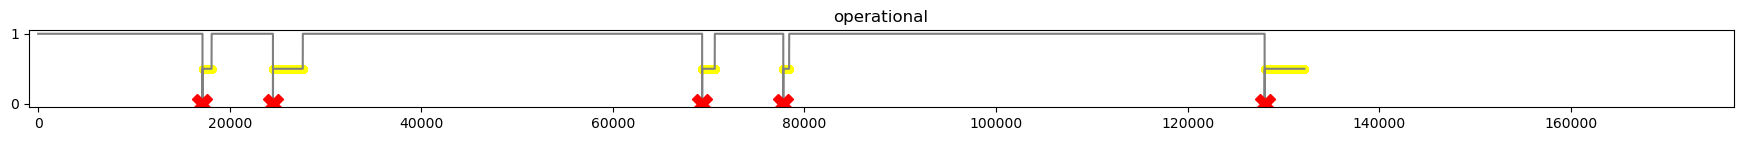

In [16]:
# Linegraphs with attributes/features highlights
for sensor in sensor_cols:
    plot = plt.figure(figsize=(22,1))
    plot = plt.plot(recovery_rows[sensor], linestyle = 'none', marker='o', color='yellow', markersize=5)
    plot = plt.plot(train[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red',markersize=14)
    plot = plt.title(sensor)
    plt.xlim((-1000, 177000))

## Preprocessing 

### Initial Pre-Processing steps

In [17]:
# split data into X and y (data and labels)         
X_cols = train.iloc[ : , 1:-2].columns

X_train = train.iloc[:,1:-2].copy()
y_train = train['machine_status']



In [18]:
# Forward fill all NA values
X_train = X_train.fillna(method='ffill')
X_train.describe()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
count,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,...,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000,132192.000000
mean,47.681367,51.087234,43.312336,583.886305,74.384402,12.775648,15.346671,14.748941,14.428174,40.200225,...,64.107414,36.097885,36.124844,43.192346,40.127640,41.513209,44.961196,42.869068,112.700175,53.028858
std,2.884607,3.444173,2.332091,149.954459,19.196125,2.680799,2.974476,2.714585,2.778930,12.633068,...,20.646110,8.799788,12.270834,12.487145,7.132876,10.225706,13.392462,8.208465,57.406946,13.608137
min,22.439240,36.545140,33.289930,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,0.000000,...,23.437500,20.833330,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370
25%,46.744790,50.390621,42.274303,624.768500,72.723895,13.201680,15.668400,15.118630,14.858220,39.546800,...,55.208330,32.812500,32.812500,39.062500,36.168980,36.458332,39.351850,38.773150,70.601850,46.585650
50%,48.046880,51.822910,43.576385,631.365700,77.527360,13.411460,16.124130,15.263310,15.082470,43.102065,...,62.239580,35.677080,35.416664,42.187500,39.351850,39.641200,43.113426,41.956017,99.537030,50.925926
75%,49.262150,53.038190,44.791664,636.574100,82.184810,13.614000,16.203700,15.545430,15.118630,46.744405,...,70.572910,38.802080,38.020832,45.572914,43.113430,43.402780,47.453700,45.428240,146.412000,56.134260
max,55.772570,56.032990,48.220490,800.000000,99.999880,22.251160,23.509840,23.307290,22.294560,76.106860,...,512.760400,219.010400,374.218800,408.593700,221.064800,220.196800,320.891200,196.759300,502.314800,323.206000


In [19]:
# normalize data 
normalize = Normalizer()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_cols

### Create the Principal Component Analysis

In [20]:
pca = PCA(n_components = .99, svd_solver = 'full', random_state = RANDNUM )
pca.fit(X_train)
print(f'Number of components after reduction: {pca.n_components_}')

Number of components after reduction: 16


In [21]:
pca.explained_variance_

array([0.09629125, 0.00890455, 0.00644001, 0.0038204 , 0.00263758,
       0.00227281, 0.00158987, 0.00131147, 0.00112446, 0.00102644,
       0.00093835, 0.00073091, 0.00055499, 0.00045077, 0.00043499,
       0.00026746])

In [22]:
pca.explained_variance_ratio_

array([0.74086909, 0.06851203, 0.04954972, 0.0293943 , 0.02029362,
       0.01748711, 0.01223256, 0.01009048, 0.00865167, 0.0078975 ,
       0.00721968, 0.00562366, 0.0042701 , 0.00346824, 0.00334683,
       0.00205787])

In [23]:
"""
This snippet to produce this readout was taken from dizzycoding.com
"""
n_comps = pca.n_components_
most_important_comps = [np.abs(pca.components_[i]).argmax() for i in range(n_comps)]
intital_features = list(X_train.columns)
most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]
dic = {'PC{}'.format(i+1): most_important_sensors[i] for i in range(n_comps)}
df1 = pd.DataFrame(sorted(dic.items()))
print("Most Important Features") 
df1

Most Important Features


,0,1
0,PC1,sensor_04
1,PC10,sensor_32
2,PC11,sensor_32
3,PC12,sensor_48
4,PC13,sensor_33
5,PC14,sensor_48
6,PC15,sensor_23
7,PC16,sensor_16
8,PC2,sensor_36
9,PC3,sensor_27


In [24]:
# Transform the data using the trained PCA model to reduce dimensionality 
reduced_x_train = pca.transform(X_train)

### Visualizations 

#### Plot the PCA's determined important sensors

array([<AxesSubplot:title={'center':'sensor_04'}>,
       <AxesSubplot:title={'center':'sensor_36'}>,
       <AxesSubplot:title={'center':'sensor_27'}>,
       <AxesSubplot:title={'center':'sensor_27'}>,
       <AxesSubplot:title={'center':'sensor_29'}>,
       <AxesSubplot:title={'center':'sensor_17'}>,
       <AxesSubplot:title={'center':'sensor_28'}>,
       <AxesSubplot:title={'center':'sensor_35'}>,
       <AxesSubplot:title={'center':'sensor_30'}>,
       <AxesSubplot:title={'center':'sensor_32'}>,
       <AxesSubplot:title={'center':'sensor_32'}>,
       <AxesSubplot:title={'center':'sensor_48'}>,
       <AxesSubplot:title={'center':'sensor_33'}>,
       <AxesSubplot:title={'center':'sensor_48'}>,
       <AxesSubplot:title={'center':'sensor_23'}>,
       <AxesSubplot:title={'center':'sensor_16'}>], dtype=object)

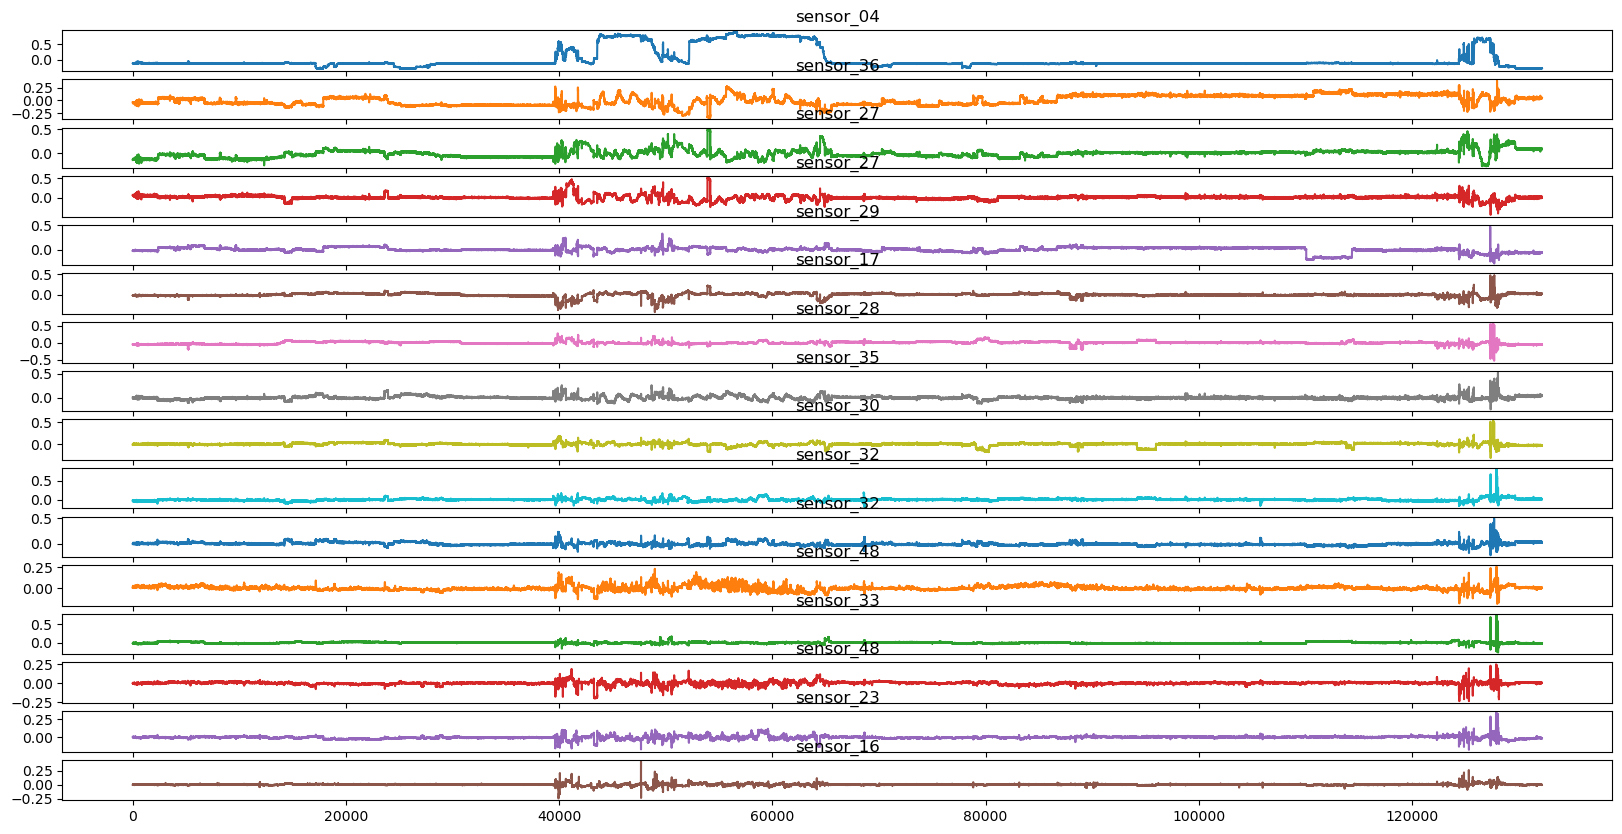

In [25]:
# Plots of the PCA determined most important sensors
pd.DataFrame(reduced_x_train).plot(subplots = True,sharex=True, figsize=(20,10), title=most_important_sensors, legend=False)

#### Generate Heatmaps using the PCA

Text(0.5, 1.0, 'Correlation Heatmap of Imporant Sensors determined by the PCA')

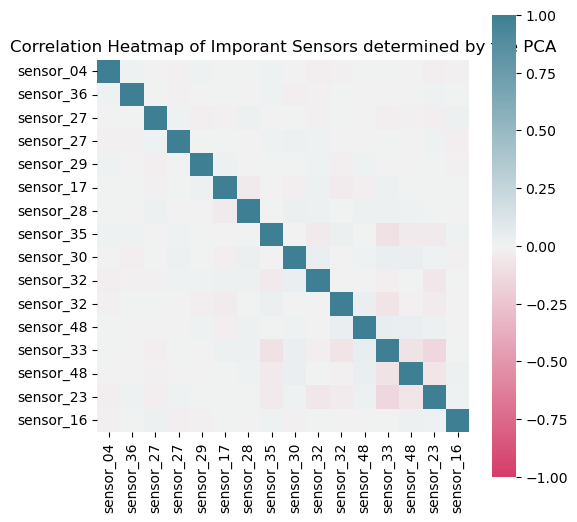

In [26]:
plt.figure(figsize=(6,6))

cmap = sns.diverging_palette(360, 220, as_cmap=True)
sns.heatmap((pd.DataFrame(reduced_x_train).sample(n=10000, replace=True, random_state=RANDNUM)).corr(), square=True, cmap=cmap, vmin = -1, vmax=1, yticklabels= most_important_sensors, xticklabels= most_important_sensors)
plt.title('Correlation Heatmap of Imporant Sensors determined by the PCA')

#### Covariance Matrix

In [27]:
pd.DataFrame(reduced_x_train, columns=most_important_sensors).sample(n=10000, replace=True).cov()

,sensor_04,sensor_36,sensor_27,sensor_27,sensor_29,sensor_17,sensor_28,sensor_35,sensor_30,sensor_32,sensor_32,sensor_48,sensor_33,sensor_48,sensor_23,sensor_16
sensor_04,0.096844,-0.000051,3.384444e-04,0.000363,-0.000094,-1.041374e-05,-0.000022,-0.000126,4.340390e-06,-0.000002,-2.609579e-05,2.709877e-06,0.000055,6.465636e-05,-0.000038,0.000050
sensor_36,-0.000051,0.009122,-1.368488e-04,-0.000064,-0.000024,-6.027670e-05,-0.000021,0.000034,3.875633e-05,-0.000007,-4.385274e-05,-2.050712e-05,-0.000042,-7.180581e-05,-0.000023,-0.000003
sensor_27,0.000338,-0.000137,6.584877e-03,0.000025,-0.000037,2.800513e-05,0.000012,-0.000018,-4.443147e-05,0.000011,3.986637e-05,7.889043e-06,0.000008,-8.333103e-07,0.000004,0.000026
sensor_27,0.000363,-0.000064,2.454805e-05,0.004199,0.000050,-4.752533e-05,0.000097,0.000013,3.310295e-05,0.000043,-5.299920e-05,6.635814e-05,0.000006,6.094474e-05,-0.000065,0.000050
sensor_29,-0.000094,-0.000024,-3.660511e-05,0.000050,0.002681,5.475075e-05,-0.000058,0.000017,-9.881528e-06,0.000022,-6.961865e-05,2.640488e-05,0.000043,8.303749e-06,0.000028,-0.000024
sensor_17,-0.000010,-0.000060,2.800513e-05,-0.000048,0.000055,2.307453e-03,-0.000029,-0.000021,-2.275381e-07,-0.000064,-3.076241e-05,-7.519974e-06,-0.000022,-2.497746e-05,0.000029,-0.000044
sensor_28,-0.000022,-0.000021,1.227933e-05,0.000097,-0.000058,-2.874470e-05,0.001582,-0.000021,7.461239e-06,-0.000012,5.425694e-05,2.572087e-05,-0.000029,1.589682e-05,-0.000031,0.000016
sensor_35,-0.000126,0.000034,-1.819602e-05,0.000013,0.000017,-2.052910e-05,-0.000021,0.001414,-1.342025e-05,0.000069,-3.482077e-05,1.634444e-06,0.000043,-9.158330e-06,0.000020,0.000022
sensor_30,0.000004,0.000039,-4.443147e-05,0.000033,-0.000010,-2.275381e-07,0.000007,-0.000013,1.116252e-03,0.000012,-4.278072e-05,1.843548e-05,-0.000011,-3.463064e-06,-0.000012,-0.000009
sensor_32,-0.000002,-0.000007,1.131550e-05,0.000043,0.000022,-6.447602e-05,-0.000012,0.000069,1.199135e-05,0.001051,-4.973442e-06,-2.514220e-05,0.000078,1.213167e-05,0.000041,-0.000001


## Modeling

In [28]:
# Generate a labeler for unservised learning 
def label_permute_compare(y,ypred, n=3):
    """A helper function to find the best label - number combo """
    results = pd.DataFrame(y)
    perms = list(itertools.permutations([0, 1, 2]))      #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['NORMAL', 'BROKEN', 'RECOVERING']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 3:
                conditions = [
                    (y['machine_status'] == current['NORMAL']),
                    (y['machine_status'] == current['BROKEN']),
                    (y['machine_status'] == current['RECOVERING'])]
                results['test'] = results['machine_status'].map(current)
                current_accuracy = accuracy_score(results['test'], ypred)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    results['best'] = results['test']
    return best_labels, best_acc

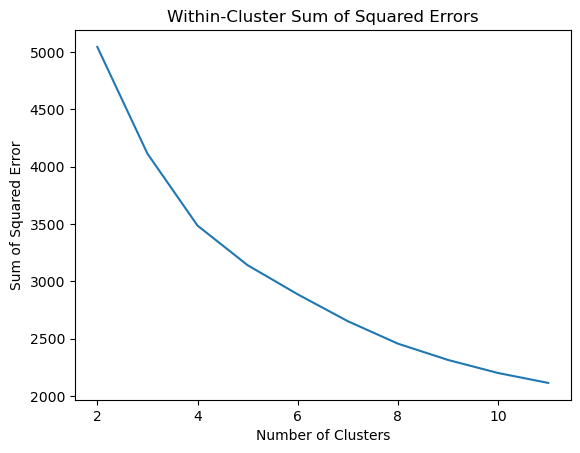

In [30]:
# Collect and Visualize error clusters
error = []
K = range(2,12)
for k in K:
    kmeans= KMeans(n_clusters=k, max_iter=500, init='k-means++', n_init=20, random_state=RANDNUM)
    kmeans_fit = kmeans.fit(reduced_x_train)
    error.append(kmeans.inertia_)
    
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')
plt.title('Within-Cluster Sum of Squared Errors')
plt.plot(K,error)